**Modules**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from symspellpy.symspellpy import SymSpell, Verbosity
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from scipy.sparse import coo_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import time
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

**Data Visualisation**

In [2]:
df_train = pd.read_csv('archive/train.csv')
df_test = pd.read_csv('archive/test.csv')

df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


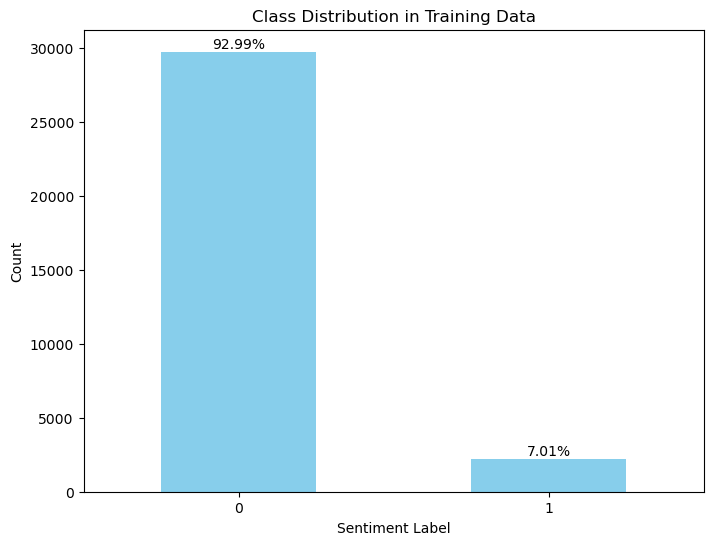

In [4]:
# Count the occurrences of each label
label_counts = df_train['label'].value_counts()

# Calculate the percentage of each class
total_samples = len(df_train)
label_percentages = (label_counts / total_samples) * 100

# Plotting the bar plot
plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Training Data')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Annotate percentages on top of each bar
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height() + 0.5,
            f'{i.get_height()/total_samples:.2%}', ha='center', va='bottom')

plt.show()

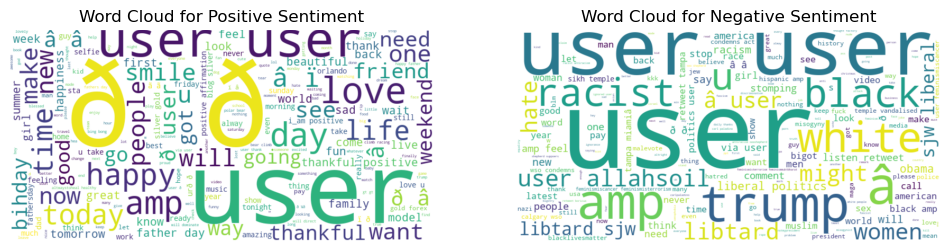

In [5]:
# Separate positive and negative sentiment tweets
positive_tweets = df_train[df_train['label'] == 0]['tweet']
negative_tweets = df_train[df_train['label'] == 1]['tweet']

# Generate word clouds for positive and negative sentiment tweets
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_tweets))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_tweets))

# Plot word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')

plt.show()

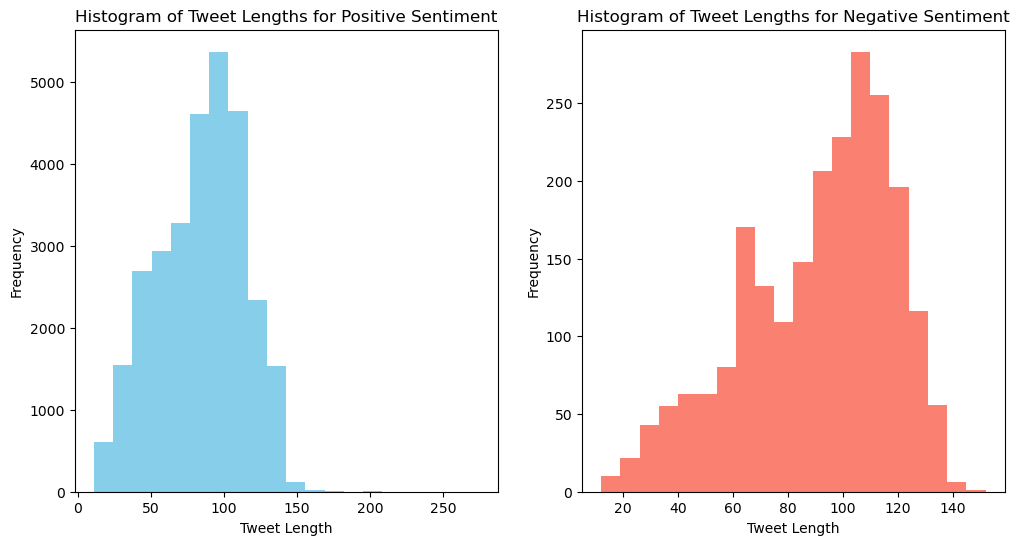

In [6]:
# Calculate tweet lengths for positive and negative sentiment tweets
positive_tweet_lengths = df_train[df_train['label'] == 0]['tweet'].apply(len)
negative_tweet_lengths = df_train[df_train['label'] == 1]['tweet'].apply(len)

# Plot histograms of tweet lengths
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(positive_tweet_lengths, color='skyblue', bins=20)
plt.title('Histogram of Tweet Lengths for Positive Sentiment')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(negative_tweet_lengths, color='salmon', bins=20)
plt.title('Histogram of Tweet Lengths for Negative Sentiment')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

plt.show()

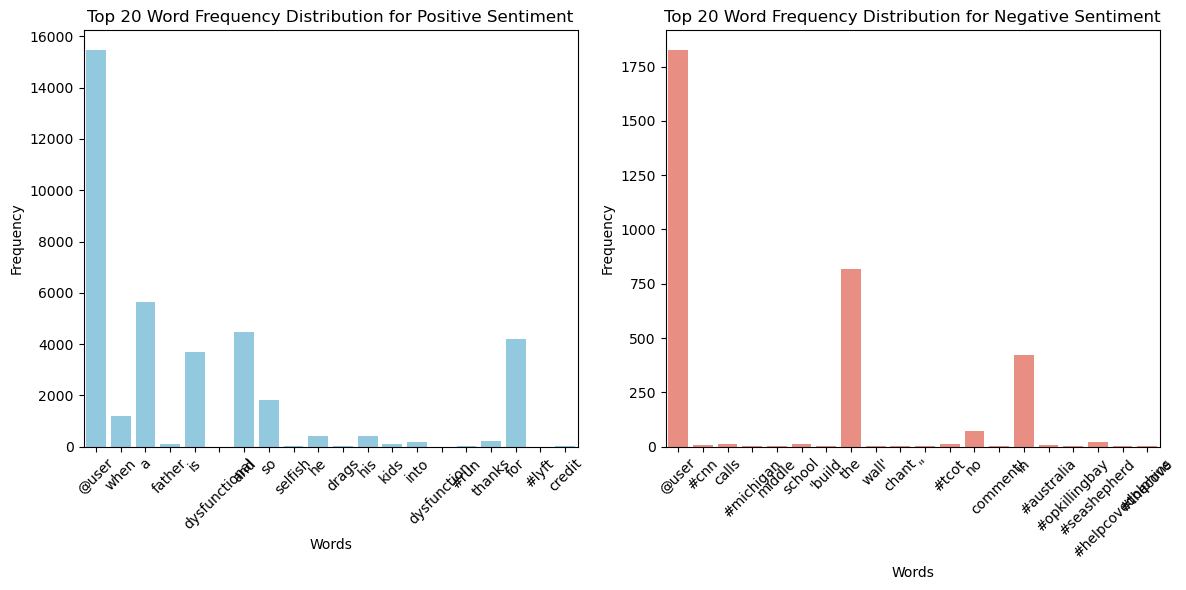

In [7]:
# Tokenize and count words for positive and negative sentiment tweets
positive_words = ' '.join(df_train[df_train['label'] == 0]['tweet']).split()
negative_words = ' '.join(df_train[df_train['label'] == 1]['tweet']).split()

# Count word frequencies
positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)

# Convert word frequencies to DataFrames
positive_word_freq_df = pd.DataFrame.from_dict(positive_word_freq, orient='index', columns=['Frequency'])
negative_word_freq_df = pd.DataFrame.from_dict(negative_word_freq, orient='index', columns=['Frequency'])

# Plot word frequency distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=positive_word_freq_df.index[:20], y=positive_word_freq_df['Frequency'][:20], color='skyblue')
plt.title('Top 20 Word Frequency Distribution for Positive Sentiment')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=negative_word_freq_df.index[:20], y=negative_word_freq_df['Frequency'][:20], color='salmon')
plt.title('Top 20 Word Frequency Distribution for Negative Sentiment')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Data Preprocessing**

In [8]:
# Convert uppercase letters to lowercase in the "tweet" column
df_train['tweet'] = df_train['tweet'].str.lower()
df_test['tweet'] = df_test['tweet'].str.lower()

In [9]:
# Function to remove punctuation from text
def remove_punctuation(text):
    # Define a regular expression pattern to match punctuation
    punctuation_pattern = r'[^\w\s]'  # Matches any character that is not a word character or whitespace
    
    # Replace punctuation with an empty string
    return re.sub(punctuation_pattern, '', text)

# Remove punctuation from the "tweet" column
df_train['tweet'] = df_train['tweet'].apply(remove_punctuation)
df_test['tweet'] = df_test['tweet'].apply(remove_punctuation)

In [10]:
# Download stopwords list
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Function to remove numbers, stopwords from text
def clean_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    return text

# Remove numbers, stopwords, and punctuations from the "tweet" column
df_train['tweet'] = df_train['tweet'].apply(clean_text)
df_test['tweet'] = df_test['tweet'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/terlan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Drop the "id" column from the training dataset
df_train = df_train.drop("id", axis=1)

# Drop the "id" column from the testing dataset
df_test = df_test.drop("id", axis=1)

In [12]:
# Tokenize words in the "tweet" column
words = ' '.join(df_train['tweet']).split()

# Count the frequency of each word
word_counts = Counter(words)

# Print the most frequent words
print("Most frequent words:")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")

Most frequent words:
user: 17473
love: 2648
ð: 2516
day: 2230
â: 1867
happy: 1663
amp: 1588
u: 1141
im: 1139
time: 1110


In [13]:
# Function to remove specific characters and the word "user" from text
def clean_text(text):
    # Remove "user"
    text = text.replace('user', '')
    
    # Remove specific characters
    text = text.replace('ð', '')
    text = text.replace('â', '')
    
    return text

# Remove "user" and specific characters from the "tweet" column in the training dataset
df_train['tweet'] = df_train['tweet'].apply(clean_text)

# Remove "user" and specific characters from the "tweet" column in the testing dataset
df_test['tweet'] = df_test['tweet'].apply(clean_text)


In [14]:
# Step 1: Identify the rare words from the training dataset
word_counts = pd.Series(' '.join(df_train['tweet']).split()).value_counts()
least_common_words = word_counts[word_counts <= 1]  # Adjust the threshold as needed

# Step 2: Define a function to remove rare words
def rare_words_removal(df, rare_words):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(word for word in x.split() if word not in rare_words))
    return df

# Step 3: Apply the function to both the training and testing datasets
df_train = rare_words_removal(df_train, least_common_words.index)
df_test = rare_words_removal(df_test, least_common_words.index)

# Print the first few rows of the cleaned datasets
print(df_train['tweet'].head())
print(df_test['tweet'].head())

0            father selfish drags kids dysfunction run
1    thanks lyft credit cant use cause dont offer w...
2                                       bihday majesty
3                          model love u take u time ur
4                        factsguide society motivation
Name: tweet, dtype: object
0    studiolife aislife requires passion dedication...
1        white want everyone see new birds movie heres
2    safe ways heal acne altwaystoheal healthy healing
3    hp child book reservations already yes harrypo...
4    rd bihday amazing hilarious nephew eli ahmir u...
Name: tweet, dtype: object


In [15]:
#Faster method of spelling correction
#Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load a frequency dictionary
dictionary_path = "frequency_dictionary_en_82_765.txt"  # Example dictionary file path
bigram_path = "frequency_bigramdictionary_en_243_342.txt"  # Example bigram dictionary file path
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Function to correct spelling using SymSpell
def correct_spelling(text):
    corrected_text = []
    for word in text.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_text.append(suggestions[0].term)
        else:
            corrected_text.append(word)
    return ' '.join(corrected_text)

# Assuming df_train and df_test are your DataFrames

# Apply the spelling correction function to both the training and testing datasets
df_train['tweet'] = df_train['tweet'].apply(correct_spelling)
df_test['tweet'] = df_test['tweet'].apply(correct_spelling)

# Print the first few rows of the cleaned datasets
print(df_train['tweet'].head())
print(df_test['tweet'].head())

2024-06-08 19:32:41,102: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en_82_765.txt.
2024-06-08 19:32:41,103: E symspellpy.symspellpy] Bigram dictionary file not found at frequency_bigramdictionary_en_243_342.txt.


0            father selfish drags kids dysfunction run
1    thanks lyft credit cant use cause dont offer w...
2                                       bihday majesty
3                          model love u take u time ur
4                        factsguide society motivation
Name: tweet, dtype: object
0    studiolife aislife requires passion dedication...
1        white want everyone see new birds movie heres
2    safe ways heal acne altwaystoheal healthy healing
3    hp child book reservations already yes harrypo...
4    rd bihday amazing hilarious nephew eli ahmir u...
Name: tweet, dtype: object


In [16]:
#Tokenization
# Download NLTK resources 
nltk.download('punkt')

# Tokenize the "tweet" column in the training dataset
df_train['tokenized_tweet'] = df_train['tweet'].apply(word_tokenize)

# Tokenize the "tweet" column in the testing dataset
df_test['tokenized_tweet'] = df_test['tweet'].apply(word_tokenize)

# Print the first few rows of the tokenized datasets
print(df_train['tokenized_tweet'].head())
print(df_test['tokenized_tweet'].head())

[nltk_data] Downloading package punkt to /Users/terlan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0     [father, selfish, drags, kids, dysfunction, run]
1    [thanks, lyft, credit, cant, use, cause, dont,...
2                                    [bihday, majesty]
3                  [model, love, u, take, u, time, ur]
4                    [factsguide, society, motivation]
Name: tokenized_tweet, dtype: object
0    [studiolife, aislife, requires, passion, dedic...
1    [white, want, everyone, see, new, birds, movie...
2    [safe, ways, heal, acne, altwaystoheal, health...
3    [hp, child, book, reservations, already, yes, ...
4    [rd, bihday, amazing, hilarious, nephew, eli, ...
Name: tokenized_tweet, dtype: object


In [17]:
#Applying TF-IDF
def compute_tf(texts):
    tf_scores = []
    for text in texts:
        tokens = nltk.word_tokenize(text)
        counter = Counter(tokens)
        total_words = len(tokens)
        tf_scores.append({word: count / total_words for word, count in counter.items()})
    return tf_scores

def compute_idf(texts):
    num_docs = len(texts)
    word_doc_count = Counter()
    for text in texts:
        tokens = set(nltk.word_tokenize(text))
        word_doc_count.update(tokens)
    idf_scores = {word: np.log(num_docs / (count + 1)) for word, count in word_doc_count.items()}
    return idf_scores

def compute_tfidf(tf_scores, idf_scores):
    tfidf_scores = []
    for tf in tf_scores:
        tfidf_scores.append({word: tf[word] * idf_scores[word] for word in tf.keys()})
    return tfidf_scores

# Sample dataset
texts = df_train['tweet'].tolist()

# Compute TF and IDF
tf_scores = compute_tf(texts)
idf_scores = compute_idf(texts)

# Compute TF-IDF
tfidf_scores = compute_tfidf(tf_scores, idf_scores)

# Convert to sparse matrix format for compatibility with ML models
def to_sparse_matrix(tfidf_scores, feature_names):
    rows, cols, data = [], [], []
    for row, tfidf in enumerate(tfidf_scores):
        for word, score in tfidf.items():
            rows.append(row)
            cols.append(feature_names.index(word))
            data.append(score)
    return coo_matrix((data, (rows, cols)), shape=(len(tfidf_scores), len(feature_names)))

feature_names = sorted(idf_scores.keys())
X = to_sparse_matrix(tfidf_scores, feature_names)
y = df_train['label']

In [18]:
for i, row in enumerate(tfidf_scores[:5]):
    print(f"Tweet {i+1}:")
    for word, score in row.items():
        print(f"  {word}: {score:.4f}")

# Convert the sparse matrix to a dense array for the first few entries and print
dense_X = X.todense()[:5]
print("\nDense Matrix Representation (First 5 entries):")
print(dense_X)

Tweet 1:
  father: 0.8596
  selfish: 1.3450
  drags: 1.4605
  kids: 0.8525
  dysfunction: 1.5456
  run: 0.9612
Tweet 2:
  thanks: 0.3893
  lyft: 0.7150
  credit: 0.6333
  cant: 0.3072
  use: 0.4682
  cause: 0.5068
  dont: 0.3178
  offer: 0.5897
  wheelchair: 0.7488
  vans: 0.7728
  pdx: 0.7488
  getthanked: 0.7728
Tweet 3:
  bihday: 1.9156
  majesty: 3.9872
Tweet 4:
  model: 0.6354
  love: 0.3604
  u: 1.0833
  take: 0.5651
  time: 0.4822
  ur: 0.6116
Tweet 5:
  factsguide: 2.6025
  society: 2.3714
  motivation: 1.7339

Dense Matrix Representation (First 5 entries):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Distribution of words after pre-processing**

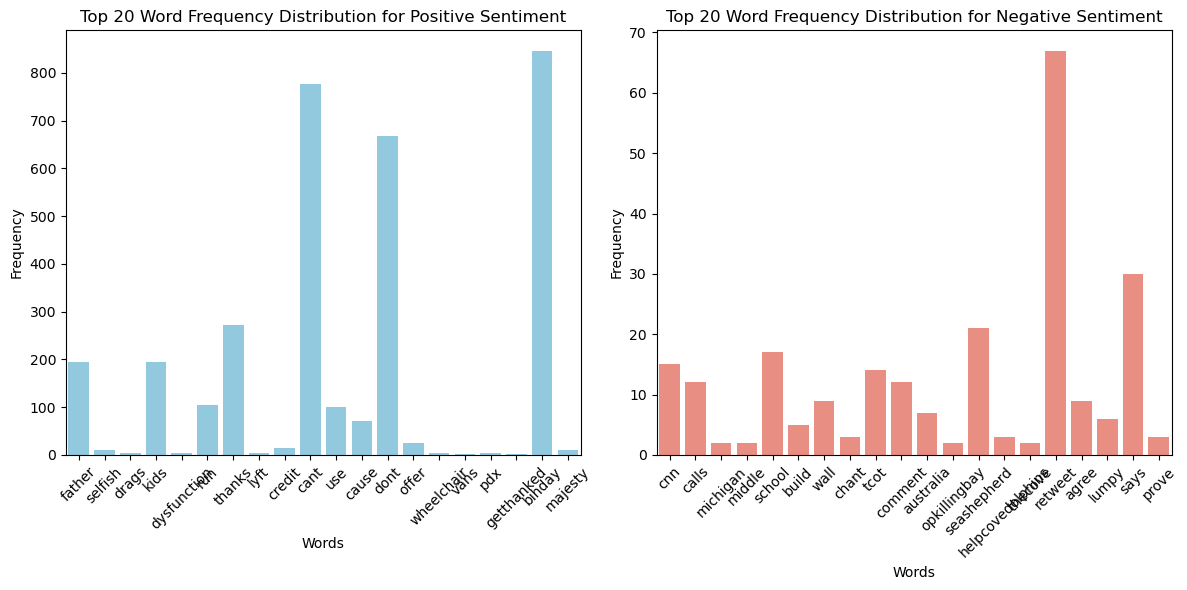

In [19]:
# Tokenize and count words for positive and negative sentiment tweets
positive_words = ' '.join(df_train[df_train['label'] == 0]['tweet']).split()
negative_words = ' '.join(df_train[df_train['label'] == 1]['tweet']).split()

# Count word frequencies
positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)

# Convert word frequencies to DataFrames
positive_word_freq_df = pd.DataFrame.from_dict(positive_word_freq, orient='index', columns=['Frequency'])
negative_word_freq_df = pd.DataFrame.from_dict(negative_word_freq, orient='index', columns=['Frequency'])

# Plot word frequency distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=positive_word_freq_df.index[:20], y=positive_word_freq_df['Frequency'][:20], color='skyblue')
plt.title('Top 20 Word Frequency Distribution for Positive Sentiment')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=negative_word_freq_df.index[:20], y=negative_word_freq_df['Frequency'][:20], color='salmon')
plt.title('Top 20 Word Frequency Distribution for Negative Sentiment')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Unbalanced data still remains as a problem**

In [20]:
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from imblearn.over_sampling import ADASYN
from keras.callbacks import EarlyStopping


#Applying TF-IDF Vectorizer and balancing only training data
# Convert tokenized tweets back to strings for TF-IDF vectorization
df_train['tweet_str'] = df_train['tokenized_tweet'].apply(lambda x: ' '.join(x))

# Apply TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df_train['tweet_str'])

# Labels
y = df_train['label']

# Step 1: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Step 2: Balance the training set using ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Print label ratio after balancing
print("Label ratio after balancing:", Counter(y_train_resampled))

# Standardize the data
scaler = StandardScaler(with_mean=False)
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)

# Convert labels to one-hot encoding
lb = LabelBinarizer()
y_train_resampled_onehot = lb.fit_transform(y_train_resampled)
y_val_onehot = lb.transform(y_val)



Label ratio after balancing: Counter({0: 23783, 1: 23334})


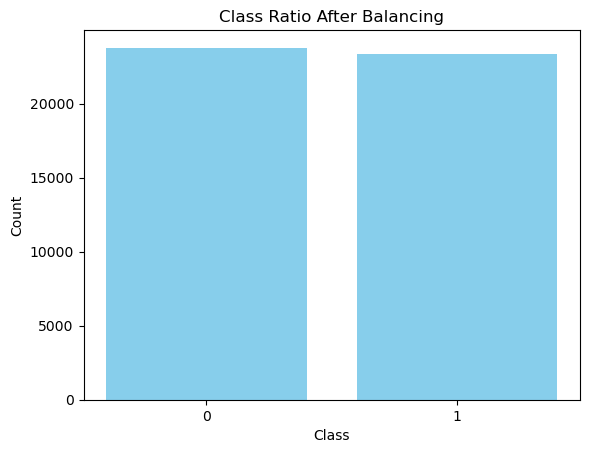

In [21]:
# Function to plot class ratio
def plot_class_ratio(y, title):
    counter = Counter(y)
    labels, values = zip(*counter.items())
    plt.bar(labels, values, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(labels)
    plt.show()

# Plot the class ratio after balancing
plot_class_ratio(y_train_resampled, 'Class Ratio After Balancing')

**Model Training**

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5937
           1       0.29      0.81      0.42       456

    accuracy                           0.84      6393
   macro avg       0.64      0.83      0.67      6393
weighted avg       0.93      0.84      0.88      6393

Accuracy Score: 0.8439
ROC-AUC Score: 0.9079



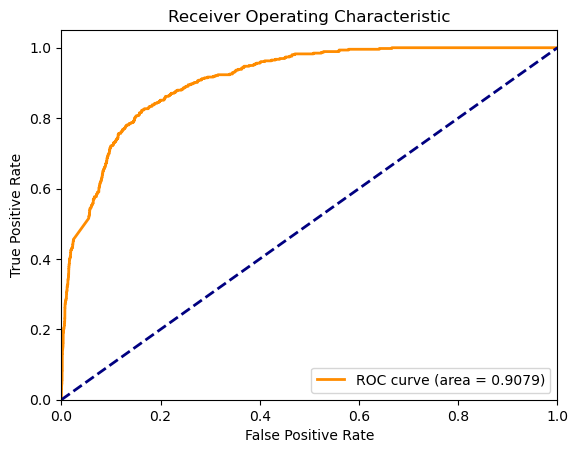

In [27]:
# Define a function to train and evaluate the model without class weights
def evaluate_model():
    model = LogisticRegression(random_state=42)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    accuracy = accuracy_score(y_val, y_pred)
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    print(f'Accuracy Score: {accuracy:.4f}')
    print(f'ROC-AUC Score: {roc_auc:.4f}\n')
    return model, y_pred_proba

# Train and evaluate the model
best_model, y_pred_proba = evaluate_model()

# Apply the best model to the validation set for ROC curve
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_val, y_val_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      5937
           1       0.24      0.85      0.37       456

    accuracy                           0.79      6393
   macro avg       0.61      0.82      0.62      6393
weighted avg       0.93      0.79      0.84      6393

Accuracy Score: 0.7924
ROC-AUC Score: 0.9018



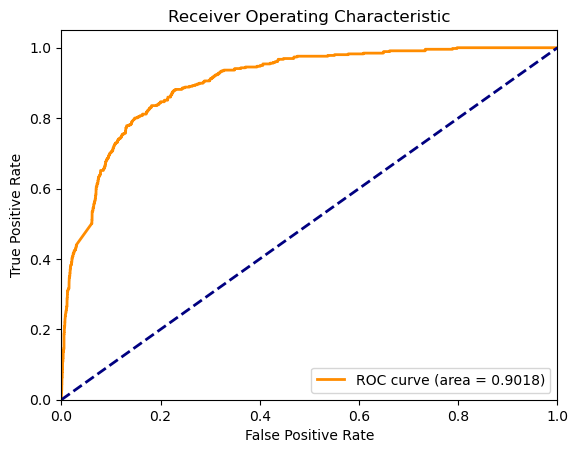

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

# Define the best parameters
#These parameters are obtained by applying GridSearch 
best_params = {'C': 0.1, 'gamma': 1, 'kernel': 'linear', 'class_weight': None}

# Define a function to train and evaluate the model with the best parameters
def evaluate_svm_model():
    model = SVC(probability=True, **best_params)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    accuracy = accuracy_score(y_val, y_pred)
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    print(f'Accuracy Score: {accuracy:.4f}')
    print(f'ROC-AUC Score: {roc_auc:.4f}\n')
    return model, y_pred_proba

# Train and evaluate the model with the best parameters
best_model, y_pred_proba = evaluate_svm_model()

# Apply the best model to the validation set for ROC curve
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_val, y_val_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Training with params: {'C': 0.1, 'gamma': 1, 'kernel': 'linear', 'class_weight': None}
F1 Score: 0.9355, ROC-AUC Score: 0.8789
Time taken: 186.99 seconds
Training with params: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf', 'class_weight': None}
F1 Score: 0.9077, ROC-AUC Score: 0.6837
Time taken: 261.61 seconds
Training with params: {'C': 0.1, 'gamma': 1, 'kernel': 'linear', 'class_weight': 'balanced'}
F1 Score: 0.8579, ROC-AUC Score: 0.8912
Time taken: 150.80 seconds
Training with params: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf', 'class_weight': 'balanced'}
F1 Score: 0.9048, ROC-AUC Score: 0.7231
Time taken: 115.69 seconds
Training with params: {'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'class_weight': None}
F1 Score: 0.9354, ROC-AUC Score: 0.8786
Time taken: 1940.32 seconds
Training with params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'class_weight': None}
F1 Score: 0.9334, ROC-AUC Score: 0.7140
Time taken: 336.47 seconds
Training with params: {'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'class_

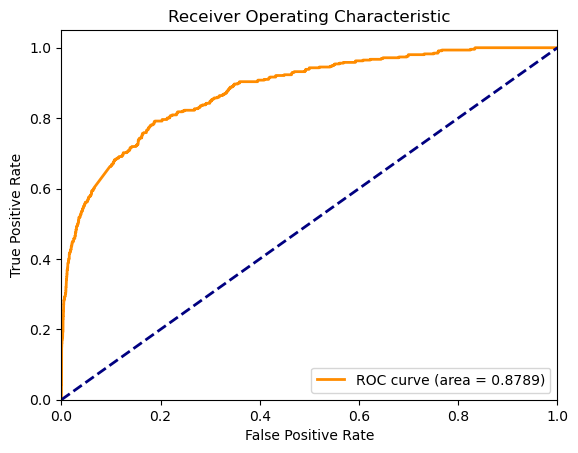

In [28]:
###########################
#GRID SEARCH CAN BE SKIPPED
###########################

# Feature Scaling for SVM
scaler = StandardScaler(with_mean=False)
X_train_resampled_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# List of parameter combinations to try
param_combinations = [
    {'C': 0.1, 'gamma': 1, 'kernel': 'linear', 'class_weight': None},
    {'C': 0.1, 'gamma': 1, 'kernel': 'rbf', 'class_weight': None},
    {'C': 0.1, 'gamma': 1, 'kernel': 'linear', 'class_weight': 'balanced'},
    {'C': 0.1, 'gamma': 1, 'kernel': 'rbf', 'class_weight': 'balanced'},
    {'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'class_weight': None},
    {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'class_weight': None},
    {'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'class_weight': 'balanced'},
    {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'class_weight': 'balanced'}
]

""""
Best parameters found:
{'C': 0.1, 'gamma': 1, 'kernel': 'linear', 'class_weight': None}
Best F1 Score: 0.9366
"""

best_score = 0
best_params = None
best_model = None

# Manual grid search
for params in param_combinations:
    start_time = time.time()
    print(f"Training with params: {params}")
    svm = SVC(**params, probability=True)
    svm.fit(X_train_resampled_scaled, y_train)
    
    # Predict on the validation set
    y_val_pred = svm.predict(X_val_scaled)
    y_val_pred_proba = svm.predict_proba(X_val_scaled)[:, 1]
    
    # Evaluate model performance
    f1 = classification_report(y_val, y_val_pred, output_dict=True)['weighted avg']['f1-score']
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    print(f"F1 Score: {f1:.4f}, ROC-AUC Score: {roc_auc:.4f}")
    print(f"Time taken: {time.time() - start_time:.2f} seconds")
    
    if f1 > best_score:
        best_score = f1
        best_params = params
        best_model = svm

print("\nBest parameters found:")
print(best_params)
print(f"Best F1 Score: {best_score:.4f}")

# Predict on the validation set using the best model
y_val_pred = best_model.predict(X_val_scaled)
y_val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]

# Print classification report
print("\nClassification Report with Best SVM Model:")
print(classification_report(y_val, y_val_pred))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Classification Report with Best Random Forest Model:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      5937
           1       0.37      0.66      0.48       456

    accuracy                           0.90      6393
   macro avg       0.67      0.79      0.71      6393
weighted avg       0.93      0.90      0.91      6393

ROC-AUC Score: 0.8938


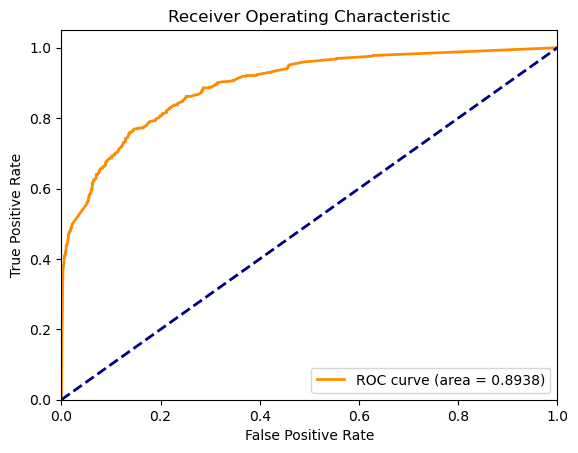

Best Parameters from Grid Search:
{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': None}


In [32]:
# Define the best parameters found using GridSearch
best_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'class_weight': None
}

# Initialize the Random Forest model with the best parameters
rf_model = RandomForestClassifier(random_state=42, **best_params)

# Train the model on the resampled data
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred = rf_model.predict(X_val)
y_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]

# Print classification report
print("Classification Report with Best Random Forest Model:")
print(classification_report(y_val, y_val_pred))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Example: Print the best parameters found
print("Best Parameters from Grid Search:")
print(best_params)

Classification Report with Best XGBoost Model:
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      5937
           1       0.14      0.91      0.25       456

    accuracy                           0.61      6393
   macro avg       0.57      0.74      0.49      6393
weighted avg       0.93      0.61      0.70      6393

ROC-AUC Score: 0.8331


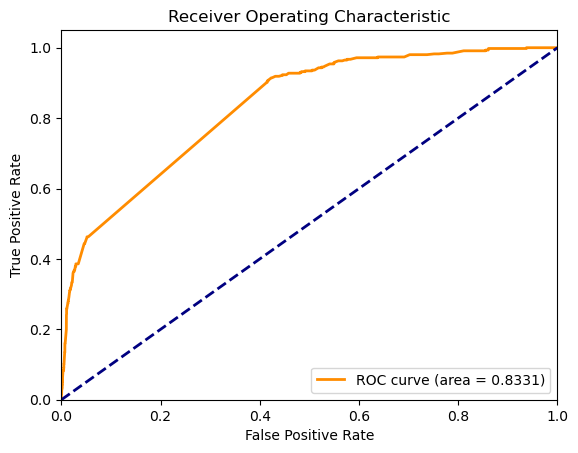

Best Parameters from Grid Search:
{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7, 'scale_pos_weight': 1}


In [33]:
# Define the best parameters found
best_params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'scale_pos_weight': 1
}

# Initialize the XGBoost model with the best parameters
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_params)

# Train the model on the resampled data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val)
y_val_pred_proba = xgb_model.predict_proba(X_val)[:, 1]

# Print classification report
print("Classification Report with Best XGBoost Model:")
print(classification_report(y_val, y_val_pred))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Example: Print the best parameters found
print("Best Parameters from Grid Search:")
print(best_params)

Epoch 1/20
737/737 [==============================] - 8s 10ms/step - loss: 0.5206 - accuracy: 0.8098 - val_loss: 0.3346 - val_accuracy: 0.8433
Epoch 2/20
737/737 [==============================] - 7s 10ms/step - loss: 0.3194 - accuracy: 0.8768 - val_loss: 0.3401 - val_accuracy: 0.8450
Epoch 3/20
737/737 [==============================] - 7s 10ms/step - loss: 0.3044 - accuracy: 0.8841 - val_loss: 0.3604 - val_accuracy: 0.8525
Epoch 4/20
200/200 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5937
           1       0.28      0.78      0.41       456

    accuracy                           0.84      6393
   macro avg       0.63      0.81      0.66      6393
weighted avg       0.93      0.84      0.87      6393

ROC-AUC Score: 0.8964


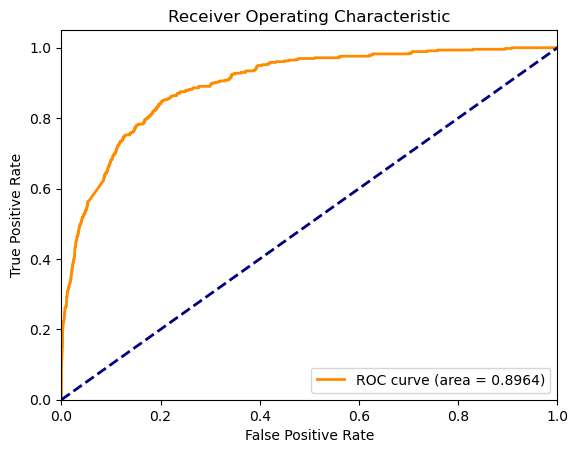

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Ensure reproducibility
np.random.seed(42)

# Standardize the data
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)

# Convert labels to one-hot encoding
lb = LabelBinarizer()
y_train_onehot = lb.fit_transform(y_train_resampled)
y_val_onehot = lb.transform(y_val)

# Step 2: Define the neural network architecture
def create_model(learning_rate=0.001, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 3: Train the model with different hyperparameters
model = create_model(learning_rate=0.001, dropout_rate=0.5)
history = model.fit(X_train_scaled.toarray(), y_train_onehot, epochs=20, batch_size=64,
                    validation_data=(X_val_scaled.toarray(), y_val_onehot), 
                    callbacks=[early_stopping], verbose=1)

# Step 4: Evaluate the model
y_val_pred_proba = model.predict(X_val_scaled.toarray()).ravel()
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Step 5: Plot the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

# Create and train GBDT classifier
gbdt_model = GradientBoostingClassifier()
gbdt_model.fit(X_train_scaled, y_train_resampled)

# Predict on validation set
y_val_pred_gbdt = gbdt_model.predict(X_val_scaled)

# Evaluate the model
print("Classification Report for GBDT:")
print(classification_report(y_val, y_val_pred_gbdt))

# Compute ROC-AUC score
roc_auc_gbdt = roc_auc_score(y_val, gbdt_model.predict_proba(X_val_scaled)[:, 1])
print(f'ROC-AUC Score for GBDT: {roc_auc_gbdt:.4f}')


Classification Report for GBDT:
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      5937
           1       0.15      0.89      0.26       456

    accuracy                           0.64      6393
   macro avg       0.57      0.76      0.51      6393
weighted avg       0.93      0.64      0.73      6393

ROC-AUC Score for GBDT: 0.8463
